In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import time
import PIL.Image as Image
import tensorflow_hub as hub
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import pathlib
dataset_url = "https://www.alfarhood.com/PublicSharedFiles/Date_Fruit_Image_Dataset_Splitted_Train.zip"
data_dir = tf.keras.utils.get_file('train.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

dataset_url2 = "https://www.alfarhood.com/PublicSharedFiles/Date_Fruit_Image_Dataset_Splitted_Test.zip"
data_dir2 = tf.keras.utils.get_file('test.tar', origin=dataset_url2, extract=True)
data_dir2 = pathlib.Path(data_dir2).with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
image_count2 = len(list(data_dir2.glob('*/*.jpg')))
print(image_count2)

1156
502


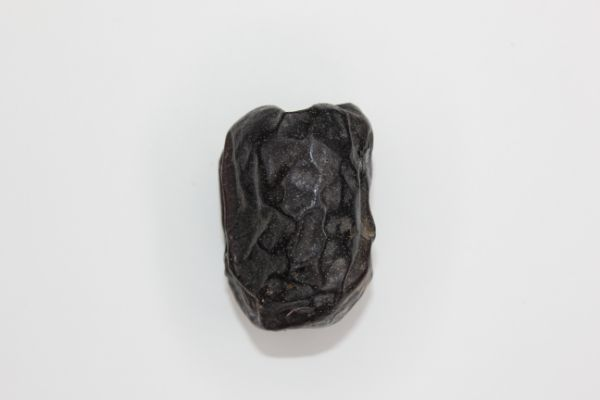

In [ ]:
Ajwa = list(data_dir.glob('Ajwa/*'))
PIL.Image.open(str(Ajwa[0]))


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 9 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 502 files belonging to 9 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Mejdool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


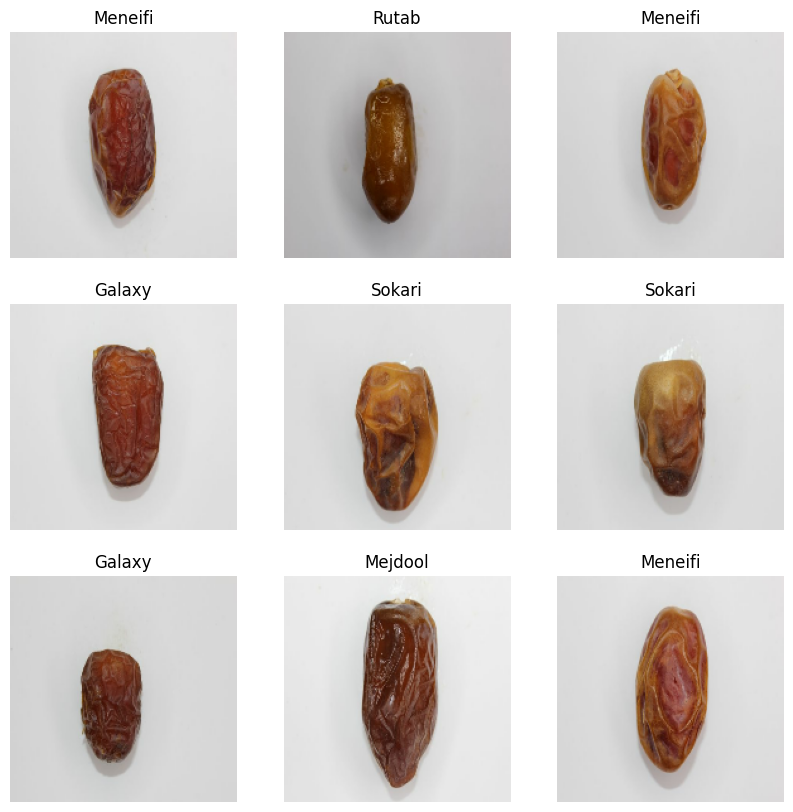

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.019064212 0.90196085


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
37/37 [==============================] - 46s 1s/step - loss: 2.2504 - accuracy: 0.1825 - val_loss: 1.9898 - val_accuracy: 0.2689
Epoch 2/10
37/37 [==============================] - 43s 1s/step - loss: 1.5654 - accuracy: 0.4221 - val_loss: 1.1634 - val_accuracy: 0.6195
Epoch 3/10
37/37 [==============================] - 44s 1s/step - loss: 0.9773 - accuracy: 0.6479 - val_loss: 0.8633 - val_accuracy: 0.6952
Epoch 4/10
37/37 [==============================] - 42s 1s/step - loss: 0.6787 - accuracy: 0.7656 - val_loss: 0.6235 - val_accuracy: 0.7669
Epoch 5/10
37/37 [==============================] - 45s 1s/step - loss: 0.5934 - accuracy: 0.7898 - val_loss: 0.5687 - val_accuracy: 0.7829
Epoch 6/10
37/37 [==============================] - 41s 1s/step - loss: 0.4422 - accuracy: 0.8538 - val_loss: 0.4813 - val_accuracy: 0.8227
Epoch 7/10
37/37 [==============================] - 40s 1s/step - loss: 0.3631 - accuracy: 0.8841 - val_loss: 0.5267 - val_accuracy: 0.8247
Epoch 8/10
37/37 [==

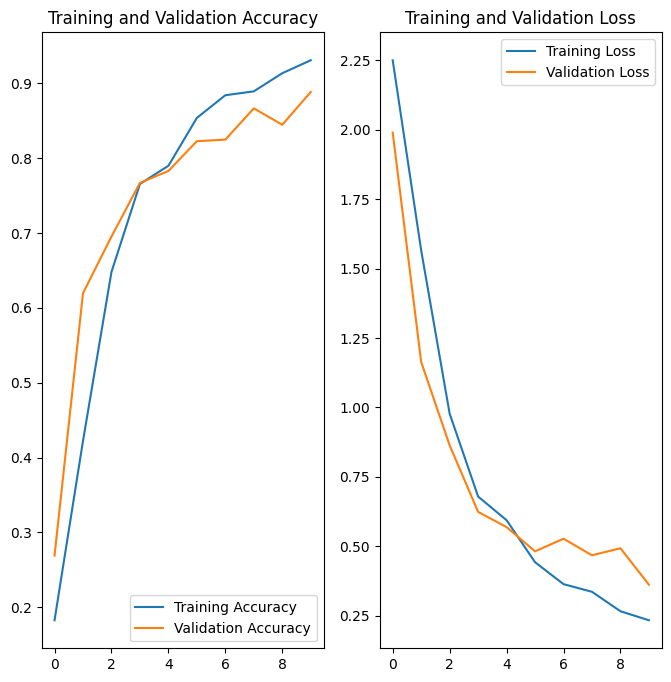

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 244ms/step
Classification Report:
               precision    recall  f1-score   support

        Ajwa       0.95      1.00      0.97        53
      Galaxy       0.98      0.75      0.85        57
     Mejdool       0.97      0.88      0.92        41
     Meneifi       0.80      0.79      0.79        70
   NabtatAli       0.92      0.83      0.87        54
       Rutab       0.80      1.00      0.89        44
     Shaishe       0.95      1.00      0.97        52
      Sokari       0.86      0.93      0.89        80
      Sugaey       0.86      0.86      0.86        51

    accuracy                           0.89       502
   macro avg       0.90      0.89      0.89       502
weighted avg       0.89      0.89      0.89       502



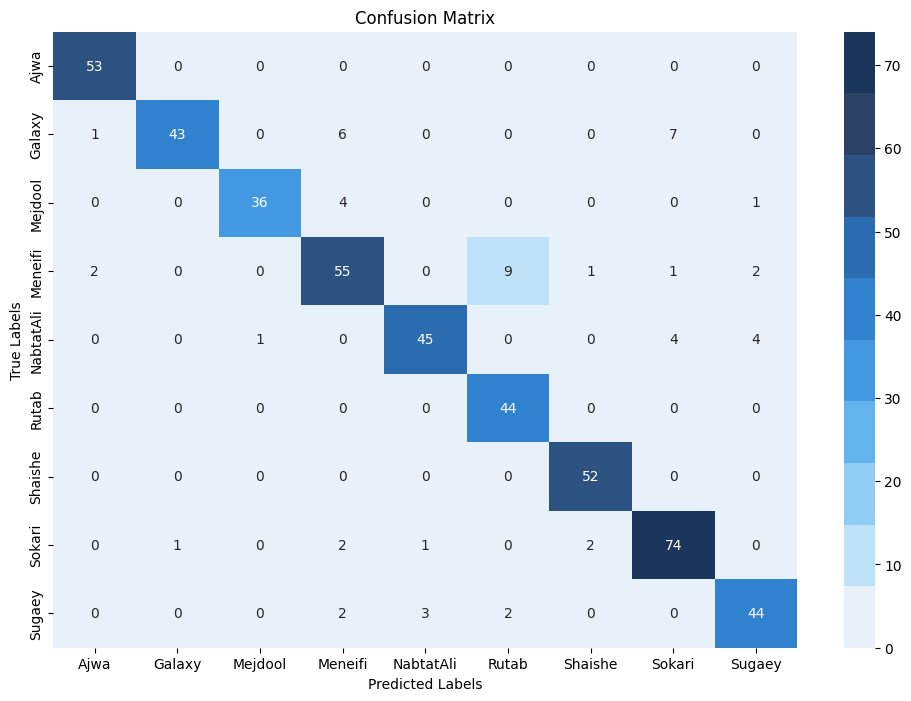

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import  confusion_matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

class_report = classification_report(y_true, y_pred, target_names=class_names)


print("Classification Report:\n", class_report)


cm = confusion_matrix(y_true, y_pred)


colors = ["#E8F1FA", "#BEE3F8", "#90CDF4", "#63B3ED", "#4299E1", "#3182CE", "#2B6CB0", "#2C5282", "#2A4365", "#1A365D"]

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap=colors, xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 [==============================] - 0s 177ms/step


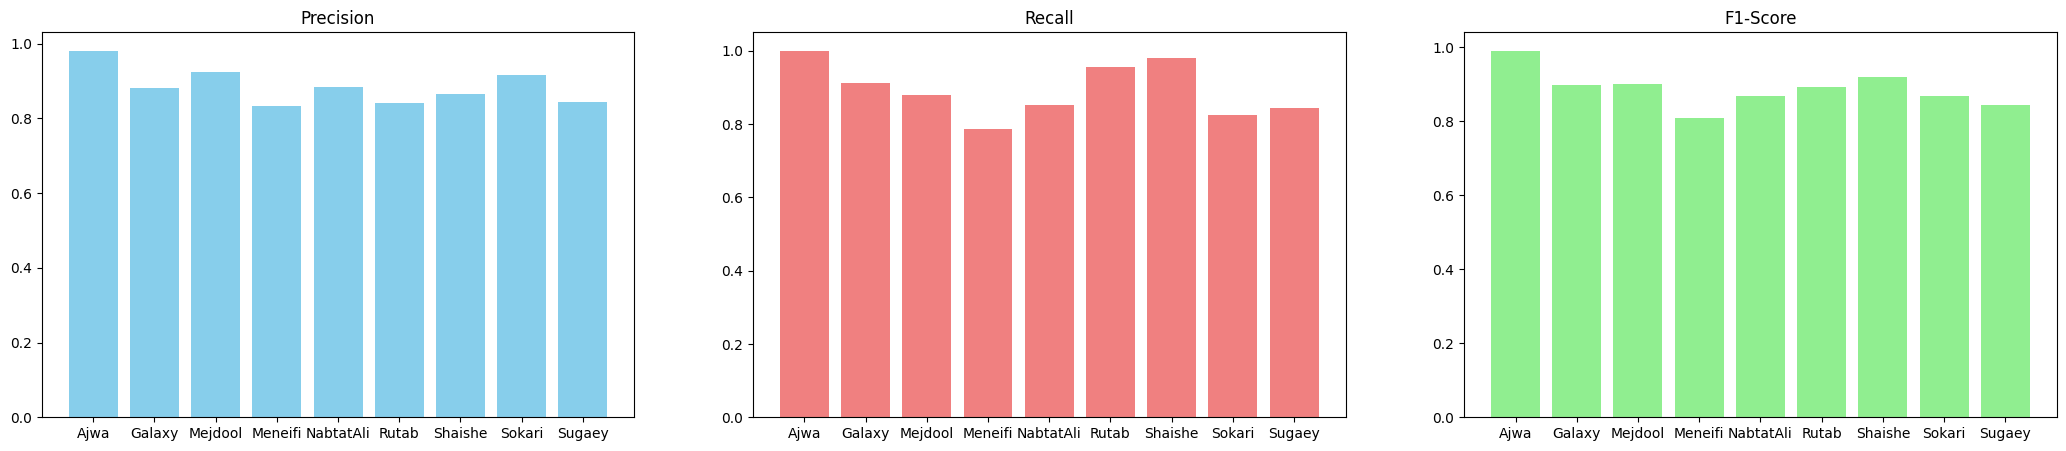

1/1 [==============================] - 0s 179ms/step
Classification Report:
               precision    recall  f1-score   support

        Ajwa       0.98      1.00      0.99       159
      Galaxy       0.88      0.91      0.90       171
     Mejdool       0.92      0.88      0.90       123
     Meneifi       0.83      0.79      0.81       210
   NabtatAli       0.88      0.85      0.87       162
       Rutab       0.84      0.95      0.89       132
     Shaishe       0.86      0.98      0.92       156
      Sokari       0.92      0.82      0.87       240
      Sugaey       0.84      0.84      0.84       153

    accuracy                           0.88      1506
   macro avg       0.89      0.89      0.89      1506
weighted avg       0.89      0.88      0.88      1506



In [ ]:
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))


class_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)


precisions = [class_report[class_name]['precision'] for class_name in class_names]
recalls = [class_report[class_name]['recall'] for class_name in class_names]
f1_scores = [class_report[class_name]['f1-score'] for class_name in class_names]


fig, axs = plt.subplots(1, 3, figsize=(26, 5))

axs[0].bar(class_names, precisions, color='skyblue')
axs[0].set_title('Precision')

axs[1].bar(class_names, recalls, color='lightcoral')
axs[1].set_title('Recall')

axs[2].bar(class_names, f1_scores, color='lightgreen')
axs[2].set_title('F1-Score')

plt.show()
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))


class_report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:\n", class_report)

<ipython-input-72-20355be051a2>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(class_names, rotation=45, ha='right')
<ipython-input-72-20355be051a2>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(class_names, rotation=45, ha='right')


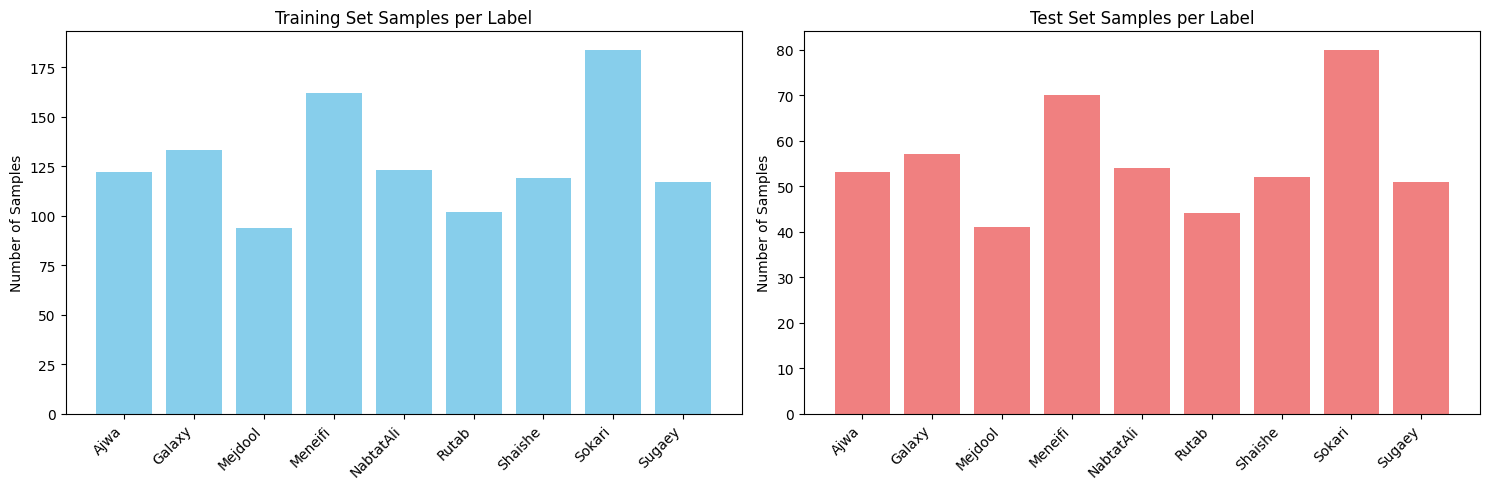

In [ ]:
import matplotlib.pyplot as plt

train_counts = [len(list(data_dir.glob(f'{class_name}/*.jpg'))) for class_name in class_names]


test_counts = [len(list(data_dir2.glob(f'{class_name}/*.jpg'))) for class_name in class_names]


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(class_names, train_counts, color='skyblue')
axs[0].set_title('Training Set Samples per Label')
axs[0].set_ylabel('Number of Samples')
axs[0].set_xticklabels(class_names, rotation=45, ha='right')

axs[1].bar(class_names, test_counts, color='lightcoral')
axs[1].set_title('Test Set Samples per Label')
axs[1].set_ylabel('Number of Samples')
axs[1].set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()